# PyTorch Tensors and Data Types

In PyTorch, **Tensors** are the basic building blocks — kind of like NumPy arrays, but with GPU support and autograd (automatic differentiation) capabilities.

Every tensor has a:
- **shape** (like `[3, 4]` for a 3×4 matrix)
- **dtype** (data type, e.g., float, int, etc.)
- **device** (CPU or GPU)

---

## Tensor Data Types (`dtype`)

Here are the most common **Tensor `dtypes`** you will encounter:

| PyTorch dtype | Meaning                  | Common when?                      |
|---------------|---------------------------|------------------------------------|
| `torch.float32` (`torch.float`) | 32-bit float | Most deep learning models |
| `torch.float64` (`torch.double`) | 64-bit float | High-precision math (rarely needed) |
| `torch.int64` (`torch.long`) | 64-bit integer | Labels for classification tasks |
| `torch.int32` (`torch.int`) | 32-bit integer | Memory-sensitive applications |
| `torch.bool` | Boolean (True/False) | Masking, conditions |

**Examples:**

```python
import torch

x = torch.tensor([1.0, 2.0, 3.0])    # default: float32
y = torch.tensor([1, 2, 3], dtype=torch.int64)  # specify int64
mask = torch.tensor([True, False, True], dtype=torch.bool)
```

**Good to know:**  
- `float32` is **default** for real numbers.
- `int64` is **default** for integers.
- You can **cast** data types using `.to(dtype)` or `.type()`.

```python
x = x.to(torch.float64)  # Change x to float64
y = y.type(torch.float32)  # Another way to cast
```

---

## Tensor Types

When you print a tensor, you'll often see its type attached:

```python
print(x)
# tensor([1., 2., 3.], dtype=torch.float64)
```

You can **check** and **change** the type explicitly:
```python
print(x.dtype)      # torch.float64
print(x.device)     # cpu (or cuda:0 if on GPU)
```

To move to GPU (if available):

```python
x = x.to('cuda')  # or x.cuda()
```

---


## Creating Tensors and Shape

This will create a tensor of size `1, 3, 2, 2`:

```python
N, C, H, W = 1, 3, 2, 2
logits = torch.zeros(N, C, H, W)

# or 

logits = torch.randn(N, C, H, W)
```
You can imagine `1` batch which has `3` channels, and each channel is `2x2`

Here we set the element of `(0,0)` in all channels:
```python
logits[0, :, 0, 0] = torch.tensor([1.0, 0.0, 0.0])   # (0,0)
```


This will create a tensor of size `4` with values `1, 3, 2, 2`:
```python
N, C, H, W = 1, 3, 2, 2
logits = torch.tensor(N, C, H, W)
```



## When to Use `.numpy()`

If your tensor is on **CPU**, and you want to work with it using **NumPy functions** (because NumPy has a ton of utilities), you can use:

```python
x_numpy = x.numpy()
```

 **Important conditions:**
- The tensor must be on **CPU** (`device='cpu'`).
- The tensor must **not require gradients** (or if it does, be careful — you will break autograd chain).

If the tensor is on **GPU**, first move it to CPU:

```python
x_cpu = x.detach().cpu().numpy()
```
or
```python
x = x.to('cpu')
x_numpy = x.numpy()
```

**Note:**  
`.numpy()` **shares memory** with the tensor.  
If you change the NumPy array, it will also change the original tensor (unless you clone).

```python
a = torch.ones(5)
b = a.numpy()
b[0] = 100
print(a)  # tensor([100.,   1.,   1.,   1.,   1.])
```

**If you want to avoid that**, use `.clone()`:

```python
x_safe = x.clone().detach().cpu().numpy()
```

---


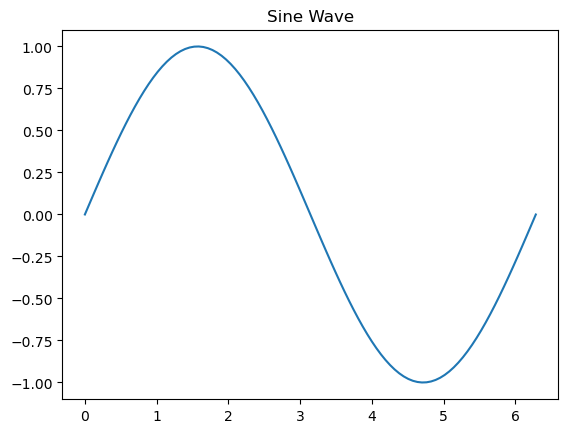

In [1]:
import torch
import matplotlib.pyplot as plt

# Suppose x is a tensor that may require gradients and may be on GPU
x = torch.linspace(0, 2 * 3.1415, 100, device='cuda', requires_grad=True)
y = torch.sin(x)

# Before plotting:
x_np = x.detach().cpu().numpy()
y_np = y.detach().cpu().numpy()


# Now plot
plt.plot(x_np, y_np)
plt.title('Sine Wave')
plt.show()

---

### **What happens if you don't know if your tensor is on CPU?**

If you call `.numpy()` **directly** on a tensor that is actually on **GPU**, **you will get an error**:

Example:
```python
import torch

x = torch.ones(3, device='cuda')  # tensor on GPU

x.numpy()  # ❌ ERROR: Can't call numpy() on Tensor that requires grad or is on GPU
```
The error says something like:
> `RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach() to get a Tensor that does not require grad.`  
or  
> `RuntimeError: Can't call numpy() on Tensor that is on GPU. Use Tensor.cpu() to copy it to CPU first.`

---

### **Is there any risk if you don't check?**

No "danger" for your program **(no memory corruption or wrong results)**.  
But it **will crash** (throw a runtime error) if you try `.numpy()` on a GPU tensor.  
So it's not dangerous — it's just *inconvenient* if you don't check.

---

###  **How to check if your tensor is on CPU or GPU?**

Every tensor has a `.device` attribute.

Example:

```python
print(x.device)
```

It prints something like:
- `cpu`
- `cuda:0`

You can also do:
```python
x.is_cuda  # returns True if on GPU
```

**Example:**

```python
if x.is_cuda:
    print("x is on GPU")
else:
    print("x is on CPU")
```

---

###  **Safe Way to Always Work**

You can always just **force** it to CPU *safely*:

```python
x_cpu = x.detach().cpu().numpy()
```

It doesn't matter if `x` was already on CPU — `.cpu()` is smart enough:
- If already on CPU → **no copy happens**.
- If on GPU → **moves to CPU**.

So doing `.cpu()` even if you're already on CPU is **perfectly fine and safe** ✅

**In short:**  
Always writing `.detach().cpu().numpy()` is 100% safe and robust.

---



| Situation | What to do |
|:----------|:-----------|
| Not sure if tensor is on CPU or GPU | `x.detach().cpu().numpy()` |
| Want to check manually | `x.device` or `x.is_cuda` |
| Risk of doing `.cpu()` even if already on CPU? | **No risk** — `.cpu()` is smart |

---



# Real-World Bugs from Forgetting `.cpu()`, `.detach()`

## Bug 1 — Forgetting `.cpu()` when plotting  
Imagine your tensor is on GPU, and you try to plot:

```python
import torch
import matplotlib.pyplot as plt

x = torch.linspace(0, 1, 100, device='cuda')
plt.plot(x.numpy())  # ❌
```
**Result:**  
```
RuntimeError: Can't call numpy() on Tensor that is on GPU. Use Tensor.cpu() to copy it to CPU first.
```

---

## Bug 2 — Forgetting `.detach()` when using `.numpy()` on tensor with gradients

```python
x = torch.randn(10, requires_grad=True)
x_numpy = x.numpy()  # ❌
```
**Result:**  
```
RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach() to get a Tensor that does not require grad.
```
Why? Because PyTorch protects the autograd graph. You could accidentally mess up gradients if you bypass it.

**Safe way:**
```python
x_numpy = x.detach().numpy()
```

---

## Bug 3 — Accidentally corrupting your tensor if you modify the NumPy array

```python
x = torch.ones(5)
x_np = x.numpy()
x_np[0] = 42  # 👀

print(x)  # tensor([42., 1., 1., 1., 1.])
```

**Explanation:**  
- `.numpy()` **shares memory** with the tensor.
- If you modify the NumPy array, you modify the tensor itself.
- If you don’t want that: do `.clone()` first.

Safe version:
```python
x_np = x.clone().detach().numpy()
```

---


### Settings default tensor type

In [2]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
a=torch.tensor(data=[2.0,3.0] )
print("Data type (torch.tensortype): ",a.type())
print("dtype (torch.dtype):", a.dtype)

Data type (torch.tensortype):  torch.cuda.FloatTensor
dtype (torch.dtype): torch.float32


/home/behnam/anaconda3/envs/PyTorchTutorial/lib/python3.12/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


[List of data types](https://pytorch.org/docs/master/tensors.html)

## Named Tensor

In [3]:
imgs = torch.randn(1, 2, 2, 3 , names=('N', 'C', 'H', 'W'))
print(imgs.names)

renamed_imgs = imgs.rename(H='height', W='width')
print(renamed_imgs.names)

imgs = torch.randn(1, 2, 2, 3 , names=(None, 'C', 'H', 'W'))

# Two names match if they are equal (string equality) or if at least one is None

x = torch.randn(3, names=('X',))
y = torch.randn(3)
z = torch.randn(3, names=('Z',))

x + y
# error
#x + z
x + x

('N', 'C', 'H', 'W')
('N', 'C', 'height', 'width')


/tmp/ipykernel_51735/2994485427.py:1: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/c10/core/TensorImpl.h:1925.)
  imgs = torch.randn(1, 2, 2, 3 , names=('N', 'C', 'H', 'W'))


tensor([ 2.2341, -0.3775, -5.0717], names=('X',))

## Random Number Generation


### How to make your **random data generation** work with a device (`cuda` or `cpu`)

Now when you create your data, just **move it to `device`** after generating it:

```python
data = (torch.rand(size=(2000, 2), generator=g) * (high - low) + low).to(device)
```

Now `self.data` will be on **GPU** if available, otherwise on **CPU**.

---

### About `torch.backends.cudnn`

- `torch.backends.cudnn.deterministic` and `torch.backends.cudnn.benchmark` are **global settings** — they always exist even if you are on CPU.
- But they **only affect GPU operations** (CuDNN is for NVIDIA GPUs).
- So you **can always** write:

```python
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
```

even if you're on CPU — PyTorch is smart enough to *ignore* it on CPU.

You don't need to check device when setting `torch.backends.cudnn` flags.

---

### Clean final code (best practice version)


torch.backends.cudnn controls low-level settings for CuDNN, the NVIDIA backend used for deep learning.

Setting:
- deterministic=True forces some algorithms to be deterministic (slower but reproducible).
- benchmark=False prevents PyTorch from trying to find the fastest algorithm (which can introduce randomness).

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Randomness control
g = torch.Generator(device=device)  # make generator on correct device
g.manual_seed(42)

torch.cuda.manual_seed(42)  # always safe, even if CPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

low = -5
high = 5

# Create data on the device
self.data = (torch.rand(size=(2000, 2), generator=g, device=device) * (high - low) + low)

# Example: select first column
first_column = self.data[:, 0]
```

---

### Important subtle thing:

When you create `Generator`, you can specify the device **at creation**:

```python
g = torch.Generator(device=device)
```

and when you call `torch.rand()`, pass `device=device` too:

```python
torch.rand(size=(...), generator=g, device=device)
```

That way, **everything is born on the right device** — no `.to(device)` copy needed later.

---

### TL;DR

- Set `device = torch.device(...)` once.  
- `torch.backends.cudnn` settings are always safe.  
- Use `.to(device)` or better: create tensors directly on the `device`.  
- Indexing `[:, 0]` works exactly like NumPy.

---


# CUDA/ GPU infomation

In [4]:
# Make Sure That Pytorch Using GPU To Compute
import torch
import os


if(torch.cuda.is_available()):
    print('cuda is available')
    print('cuda device count',torch.cuda.device_count())
    print('current device is:',torch.cuda.current_device())
    print('device name',torch.cuda.get_device_name(0))
    print('nvcc version: ')
    os.system('nvcc --version')
    print('nvidia-smi:')
    os.system('nvidia-smi')


cuda is available
cuda device count 1
current device is: 0
device name NVIDIA GeForce RTX 3050 Ti Laptop GPU
nvcc version: 
nvidia-smi:
Sat Sep 27 12:04:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0             13W /   60W |     118MiB /   4096MiB |      8%      Default |
|   

sh: 1: nvcc: not found
